# Analysis of the Mana Cost of Flying in Magic: The Gathering

Todd W. Neller

March 6th, 2019

In this notebook, we demonstrate the use of Python regression tools to help us answer the question "What is the converted mana cost (CMC) premium paid for a "Magic: The Gathering" (MTG) card with "Flying", i.e. how much extra must a player pay in game resources to bring a flying creature onto the battlefield versus a non-flying creature.

We begin with the necessary imports.

In [1]:
import json
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from IPython import display

Next, we read in all of the February 25th, 2019 MTG card data from the JSON file retrieved from https://mtgjson.com/files/all-cards/ .

In [2]:
with open('AllCards.json', 'r', encoding='utf8') as read_file:
    data = json.load(read_file)
print(len(data), 'cards read.')

19386 cards read.


We define is_number, a helper function that tests whether or not a JSON string entry parses as a float:

In [3]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

Conservatively, we collect names of creatures with "Flying"-only or no rules text and output a CSV file with
card name, power, toughness, 0/1 for flying/non-flying respectively, converted mana cost (CMC):

In [4]:
creatures = []  # list of creature names with numeric power and toughness and lacking transform layout
flying_creatures = []  # subset of creature names with rule text indicating "Flying" only
non_flying_creatures = []  # subset of creature names with blank rule text
for card_name in data:
    card_data = data[card_name]
    card_types = [] if 'types' not in card_data else card_data['types']
    if 'Creature' in card_types \
            and 'power' in card_data and is_number(card_data['power']) \
            and 'toughness' in card_data and is_number(card_data['toughness'])\
            and 'transform' not in card_data['layout']:  # Note: prominent outliers were all transform back sides
        creatures.append(card_name)
        card_text = '' if 'text' not in card_data else card_data['text']
        isFlying = False
        if card_text == 'Flying':
            isFlying = True
            flying_creatures.append(card_name)
        elif card_text == '':
            non_flying_creatures.append(card_name)
        else:
            continue
        print("\"{}\", {}, {}, {}, {}".format(card_name, card_data['power'], card_data['toughness'],
              1 if isFlying else 0, card_data['convertedManaCost']))
print(len(creatures), 'creatures found.')
print(len(flying_creatures), 'flying creatures filtered.')
print(len(non_flying_creatures), 'non-flying creatures filtered.')

"Alaborn Trooper", 2, 3, 0, 3.0
"Alpha Myr", 2, 1, 0, 2.0
"Alpha Tyrranax", 6, 5, 0, 6.0
"Alpine Grizzly", 4, 2, 0, 3.0
"Amphin Cutthroat", 2, 4, 0, 4.0
"Ancient Brontodon", 9, 9, 0, 8.0
"Ancient Carp", 2, 5, 0, 5.0
"Ancient Crab", 1, 5, 0, 3.0
"Armored Cancrix", 2, 5, 0, 5.0
"Armored Pegasus", 1, 2, 1, 2.0
"Armored Warhorse", 2, 3, 0, 2.0
"Armored Whirl Turtle", 0, 5, 0, 3.0
"Armored Wolf-Rider", 4, 6, 0, 5.0
"Arrogant Vampire", 4, 3, 1, 5.0
"Assault Griffin", 3, 2, 1, 4.0
"Aven Envoy", 0, 2, 1, 1.0
"Aven Sentry", 3, 2, 1, 4.0
"Aven Skirmisher", 1, 1, 1, 1.0
"Axebane Beast", 3, 4, 0, 4.0
"Axebane Stag", 6, 7, 0, 7.0
"Axegrinder Giant", 6, 4, 0, 6.0
"Azure Drake", 2, 4, 1, 4.0
"Balduvian Barbarians", 3, 2, 0, 3.0
"Balduvian Bears", 2, 2, 0, 2.0
"Bane Alley Blackguard", 1, 3, 0, 2.0
"Barbarian Horde", 3, 3, 0, 4.0
"Barbary Apes", 2, 2, 0, 2.0
"Barbtooth Wurm", 6, 4, 0, 6.0
"Barktooth Warbeard", 6, 5, 0, 7.0
"Barony Vampire", 3, 2, 0, 3.0
"Bartizan Bats", 3, 1, 1, 4.0
"Bastion Enforcer",

In the code above, we also excluded creatures with the "transform" layout.  These are significant outliers, as the mana cost of the initial non-flying card side does not meet the full requirement to flip, i.e. transform, the card to the flying creature on the opposite side of such cards.

The CSV data above could be useful for further analysis with other tools, but we will work with Python arrays, and pandas DataFrame objects.  Given our target creature names, we create arrays of this data, create pandas DataFrames from those arrays, and summarize the data.

In [5]:
flying_data = ([float(data[card_name]['power']), float(data[card_name]['toughness']), 1,
                data[card_name]['convertedManaCost']] for card_name in flying_creatures)
non_flying_data = ([float(data[card_name]['power']), float(data[card_name]['toughness']), 0,
                    data[card_name]['convertedManaCost']] for card_name in non_flying_creatures)
all_data = list(flying_data) + list(non_flying_data)
full_df = DataFrame(all_data, columns=['power', 'toughness', 'flying', 'cmc'])
full_df = full_df.sample(frac=1, random_state=0).reset_index(drop=True)  # shuffle DataFrame
print(full_df.describe(include='all'))

            power   toughness      flying         cmc
count  393.000000  393.000000  393.000000  393.000000
mean     2.914758    3.057252    0.206107    3.446565
std      1.751380    1.743766    0.405024    1.650508
min      0.000000    0.500000    0.000000    0.000000
25%      2.000000    2.000000    0.000000    2.000000
50%      3.000000    3.000000    0.000000    3.000000
75%      4.000000    4.000000    0.000000    5.000000
max     10.000000   10.000000    1.000000    8.000000


We would like to visualize this data with a scatterplot, but overlap of (power, toughness, CMC) points prevents us from getting a sense of the density of data points for different values.  One solution is to "jitter" the points.  We thus create a helper function, jitter_arr, that, given a numeric array, returns a jittered numeric array for jittering plot data.

In [6]:
def jitter_arr(arr):
    stdev = .02 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

Now we can scatterplot our data, showing flying and non-flying creatures as blue triangles and red circles, respectively.

<IPython.core.display.Javascript object>


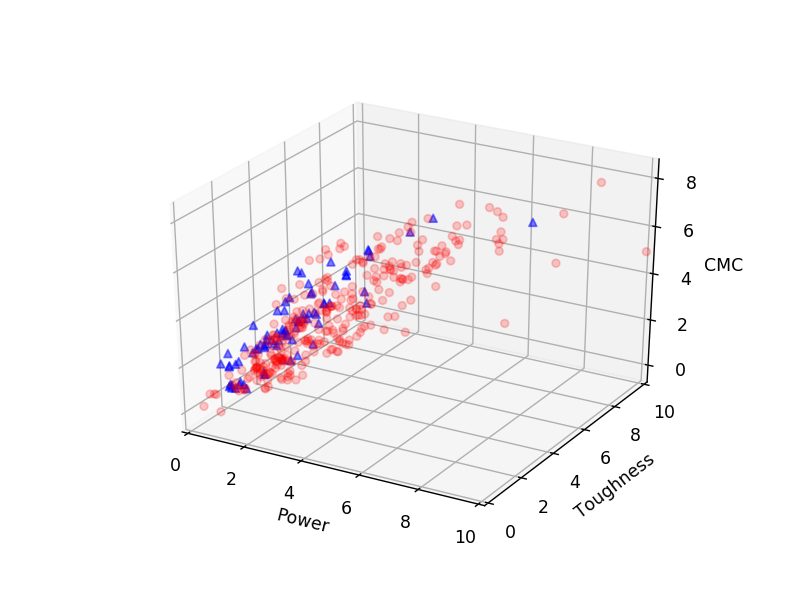

In [7]:
%matplotlib notebook
minval = 0
maxval = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((minval, maxval))
ax.set_ylim((minval, maxval))
for f, c, m, a in [(0, 'r', 'o', .2), (1, 'b', '^', .5)]:
    xs = list(full_df.loc[full_df['flying'] == f]['power'])
    ys = list(full_df.loc[full_df['flying'] == f]['toughness'])
    zs = list(full_df.loc[full_df['flying'] == f]['cmc'])
    ax.scatter(jitter_arr(xs), jitter_arr(ys), jitter_arr(zs), c=c, marker=m, alpha=a)
ax.set_xlabel('Power')
ax.set_ylabel('Toughness')
ax.set_zlabel('CMC')
plt.show()

A scikit least-squares linear regression is performed and we print the linear model computed.

https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares

In [8]:
X = full_df[['power', 'toughness', 'flying']].values
y = full_df['cmc'].values
reg = LinearRegression().fit(X, y)
print('Linear regression model:\ncmc = {} * power\n    + {} * toughness\n    + {} * flying\n    + {}'
      .format(reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.intercept_))
print('R-squared value: ', reg.score(X, y))

Linear regression model:
cmc = 0.6111629366158998 * power
    + 0.41265041398361274 * toughness
    + 0.60820253825056 * flying
    + 0.2782416745722158
R-squared value:  0.820329240737


From this analysis, we estimate the cost of flying, i.e. the flying premium, to be about **0.61 CMC**.

However, when we plot the linear regression planes against our prior scatterplot, we can better see nonlinearity in our dataset.

<IPython.core.display.Javascript object>


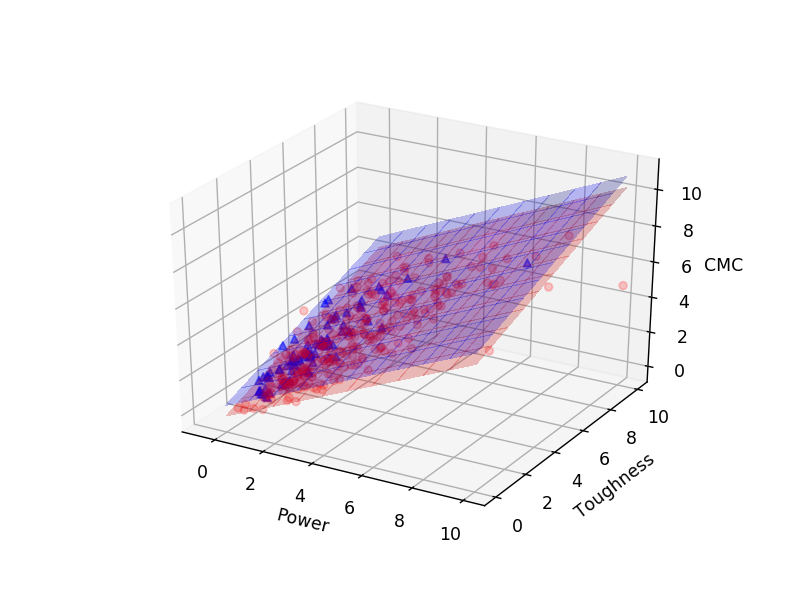

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for f, c, m, a in [(0, 'r', 'o', .2), (1, 'b', '^', .5)]:
    xs = list(full_df.loc[full_df['flying'] == f]['power'])
    ys = list(full_df.loc[full_df['flying'] == f]['toughness'])
    zs = list(full_df.loc[full_df['flying'] == f]['cmc'])
    ax.scatter(jitter_arr(xs), jitter_arr(ys), jitter_arr(zs), c=c, marker=m, alpha=a)
ax.set_xlabel('Power')
ax.set_ylabel('Toughness')
ax.set_zlabel('CMC')

# Make flying predictions and plot surface.
x_vals = np.arange(minval, maxval + 1, 1)
y_vals = np.arange(minval, maxval + 1, 1)
Xs, Ys = np.meshgrid(x_vals, y_vals)
Zs = reg.coef_[0]*Xs + reg.coef_[1]*Ys + reg.coef_[2]
ax.plot_surface(Xs, Ys, Zs, color='b', alpha=.25, linewidth=0, antialiased=False)

# Make non-flying predictions and plot surface.
Zs = reg.coef_[0]*Xs + reg.coef_[1]*Ys
ax.plot_surface(Xs, Ys, Zs, color='r', alpha=.25, linewidth=0, antialiased=False)

plt.show()  # We see against these planes that the data is nonlinear.

We can create a better nonlinear model using scikit's gradient-boosted regression trees (GBRTs).

https://scikit-learn.org/stable/modules/ensemble.html#regression

Advice for tuning the parameters may be found at https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/ .

In [10]:
train_set_size = int(2 * X.shape[0] / 3)
X_train, X_test = X[:train_set_size, :], X[train_set_size:, :]
y_train, y_test = y[:train_set_size], y[train_set_size:]
est = GradientBoostingRegressor(learning_rate=.1, n_estimators=40, verbose=False,
                                random_state=0, subsample=.7,
                                max_depth=3, loss='ls').fit(X_train, y_train)
print('Gradient-boosted regression tree mean squared error:', mean_squared_error(y_test, est.predict(X_test)))

Gradient-boosted regression tree mean squared error: 0.375293295968


Plotting the GBRT prediction surfaces, we see a better fit:

<IPython.core.display.Javascript object>


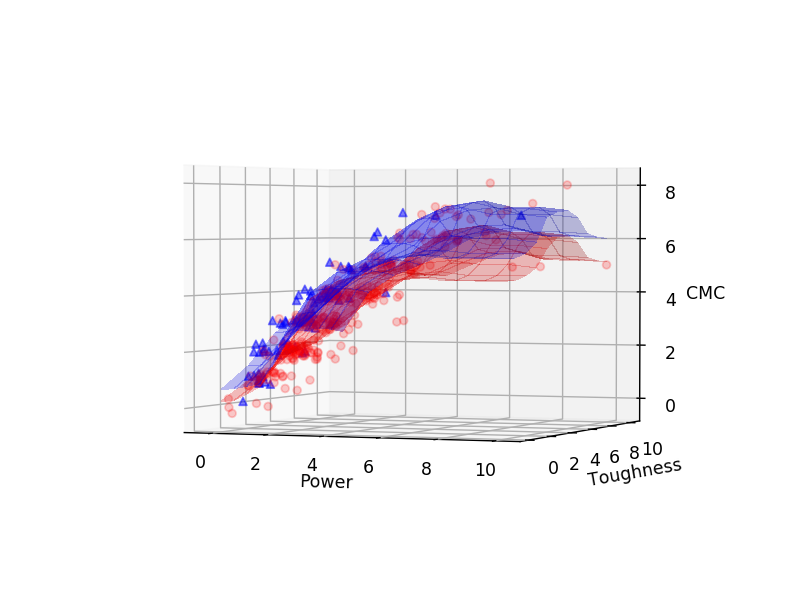

In [11]:
# Replot scatterplot.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for f, c, m, a in [(0, 'r', 'o', .2), (1, 'b', '^', .5)]:
    xs = list(full_df.loc[full_df['flying'] == f]['power'])
    ys = list(full_df.loc[full_df['flying'] == f]['toughness'])
    zs = list(full_df.loc[full_df['flying'] == f]['cmc'])
    ax.scatter(jitter_arr(xs), jitter_arr(ys), jitter_arr(zs), c=c, marker=m, alpha=a)
ax.set_xlabel('Power')
ax.set_ylabel('Toughness')
ax.set_zlabel('CMC')

# Make flying predictions and plot surface.
Zs = est.predict(np.c_[Xs.ravel(), Ys.ravel(), np.ones(Xs.shape).ravel()])
flying_Zs = Zs.reshape(Xs.shape)
surf = ax.plot_surface(Xs, Ys, flying_Zs, color='b', alpha=.25, linewidth=0, antialiased=False)

# Make non-flying predictions and plot surface.
Zs = est.predict(np.c_[Xs.ravel(), Ys.ravel(), np.zeros(Xs.shape).ravel()])
non_flying_Zs = Zs.reshape(Xs.shape)
ax.plot_surface(Xs, Ys, non_flying_Zs, color='r', alpha=.25, linewidth=0, antialiased=False)
plt.show()

Providing a tabular summary of the gradient-boosted regression tree flying premium, we can observe how the premium varies with power (rows) and toughness (columns):


In [12]:
premium_Zs = flying_Zs - non_flying_Zs
flying_premium_df = DataFrame(premium_Zs, columns=y_vals, index=x_vals)
flying_premium_df = flying_premium_df.round(1)
print('Flying premium given power (row) and toughness (column):')
display.display(flying_premium_df)

Flying premium given power (row) and toughness (column):


0    1    2    3    4    5    6    7    8    9    10
0   0.4  0.5  0.8  1.1  1.2  1.1  0.8  0.8  0.8  0.8  0.8
1   0.4  0.5  0.8  1.1  1.2  1.1  0.8  0.8  0.8  0.8  0.8
2   0.3  0.4  0.7  0.9  1.2  1.1  0.8  0.8  0.8  0.8  0.8
3   0.1  0.2  0.4  0.7  1.0  1.0  0.9  0.9  0.9  0.9  0.9
4   0.2  0.3  0.5  0.8  1.2  1.3  1.1  1.1  1.1  1.1  1.1
5   0.1  0.2  0.3  0.5  1.0  1.1  0.9  0.9  0.9  0.9  0.9
6  -0.0  0.1  0.3  0.4  0.9  1.0  0.9  0.9  0.9  0.9  0.9
7  -0.0  0.1  0.3  0.4  0.9  1.0  0.9  0.9  0.9  0.9  0.9
8  -0.0  0.1  0.3  0.4  0.9  1.0  0.8  0.8  0.9  0.9  0.9
9  -0.0  0.1  0.3  0.4  0.9  1.0  0.8  0.8  0.9  0.9  0.9
10 -0.0  0.1  0.3  0.4  0.9  1.0  0.8  0.8  0.9  0.9  0.9

Note that the flying premium is variable, peaking at 4-5 toughness, decreasing with power for low toughness, and peaking a bit at 4 power for higher toughness.

Given the negative values, it's likely that outlier predictions where data points are sparse are not not meaningful.
Therefore, we compute a sample-weighted mean of premiums.  That is, each (power, toughness) flying premium is weighted by the number of values with that (power, toughness) in our dataset.

In [13]:
num_samples = X.shape[0]
average_flying_cost = 0
for i in range(num_samples):
    average_flying_cost += (est.predict([[X[i][0], X[i][1], 1]]) - est.predict([[X[i][0], X[i][1], 0]]))[0]
average_flying_cost /= num_samples
print('Average sample-weighted cost of flying (CMC):', round(average_flying_cost, 3))

Average sample-weighted cost of flying (CMC): 0.725


# Conclusion
Linear regression on our simple flying and non-flying creatures would indicate a flying cost of **0.61 CMC**.  However, nonlinearity in the data makes the use of linear regression questionable.
Creating a CMC cost predictor using gradient-boosted regression trees, we see that the flying premium is variable, peaking at 4-5 toughness, decreasing with power for low toughness, and peaking a bit at 4 power for higher toughness.  The average sample-weighted cost of flying is **0.725 CMC**.